In [2]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
#from keras.layers.core import Activation, Flatten, Dropout, Dense
from tensorflow.keras.layers import Activation, Dense ,Flatten ,Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
#from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
EPOCHS = 80
INIT_LR = 1e-5
BS = 16
default_image_size = tuple((224,224))
image_size = 0
directory_root = '/kaggle/input/paddy-diseases/paddy_diseases'
width=256
height=256
depth=3

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200000]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing hispa ...
[INFO] Processing leaf folder ...
[INFO] Processing BLB ...
[INFO] Processing Blast ...
[INFO] Processing healthy ...
[INFO] Processing leaf spot ...
[INFO] Image loading completed


In [6]:
image_size = len(image_list)
image_size

636

In [7]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [8]:
print(label_binarizer.classes_)

['BLB' 'Blast' 'healthy' 'hispa' 'leaf folder' 'leaf spot']


In [9]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [10]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


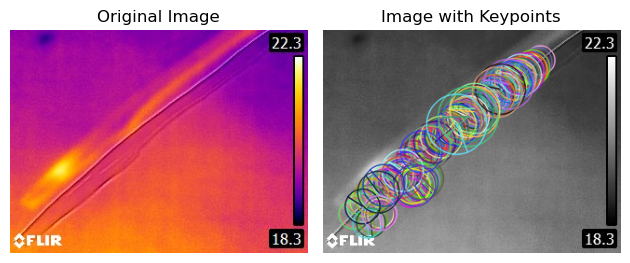

In [11]:
import cv2
import matplotlib.pyplot as plt


def detect_keypoints(image_path):
    # Load the thermal image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Initialize the ORB detector
    orb = cv2.ORB_create()

    # Find keypoints and descriptors
    keypoints, descriptors = orb.detectAndCompute(image, None)

    # Draw the keypoints on the image
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return image_with_keypoints

if __name__ == "__main__":
    # Replace 'thermal_image.jpg' with the path to your thermal plant image
    image_path = '/kaggle/input/paddy-diseases/paddy_diseases/thermal images UL/hispa/thermalimage1e.jpg'

    # Detect keypoints in the thermal image
    result_image = detect_keypoints(image_path)

    # Show the original and keypoints-annotated images
    plt.subplot(121), plt.imshow(cv2.imread(image_path, cv2.IMREAD_COLOR)[:, :, ::-1])
    plt.title('Original Image'), plt.axis('off')

    plt.subplot(122), plt.imshow(result_image[:, :, ::-1])
    plt.title('Image with Keypoints'), plt.axis('off')

    plt.tight_layout()
    plt.show()

In [12]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [13]:
# Building the model

num_classes = 6
# Initialising the model VGG 16
model = Sequential()


# Stage 1
model.add(Conv2D(input_shape = (224, 224, 3), filters = 64, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))


# Stage 2
model.add(Conv2D(filters = 128, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(Conv2D(filters = 128, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))


# Stage 3
model.add(Conv2D(filters = 256, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(Conv2D(filters = 256, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(Conv2D(filters = 256, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))


# Stage 4
model.add(Conv2D(filters = 512, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(Conv2D(filters = 512, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(Conv2D(filters = 512, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))


# Stage 5
model.add(Conv2D(filters = 512, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(Conv2D(filters = 512, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(Conv2D(filters = 512, kernel_size = (3, 3), strides=(1, 1), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))


# Stage 6
model.add(Flatten())
model.add(Dense(units = 4096, activation='relu'))
model.add(Dense(units = 4096, activation='relu'))
model.add(Dense(units = num_classes, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [15]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=INIT_LR), metrics=['accuracy'])

In [16]:
# Train the model
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/80
31/31 [==============================] - 17s 385ms/step - loss: 1.6903 - accuracy: 0.3496 - val_loss: 1.6614 - val_accuracy: 0.3125
Epoch 2/80
31/31 [==============================] - 7s 209ms/step - loss: 1.6345 - accuracy: 0.3394 - val_loss: 1.6645 - val_accuracy: 0.3125
Epoch 3/80
31/31 [==============================] - 7s 211ms/step - loss: 1.5759 - accuracy: 0.3659 - val_loss: 1.5543 - val_accuracy: 0.3359
Epoch 4/80
31/31 [==============================] - 7s 209ms/step - loss: 1.4437 - accuracy: 0.4207 - val_loss: 1.3190 - val_accuracy: 0.4219
Epoch 5/80
31/31 [==============================] - 7s 209ms/step - loss: 1.3338 - accuracy: 0.4695 - val_loss: 1.1912 - val_accuracy: 0.5781
Epoch 6/80
31/31 [==============================] - 7s 210ms/step - loss: 1.2043 - accuracy: 0.5142 - val_loss: 1.0910 - val_accuracy: 0.6328
Epoch 7/80
31/31 [==============================] - 7s 231ms/step - loss: 1.2269 - accuracy: 0.5366 - val_loss: 1.0592 - val_accuracy: 0.6016
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


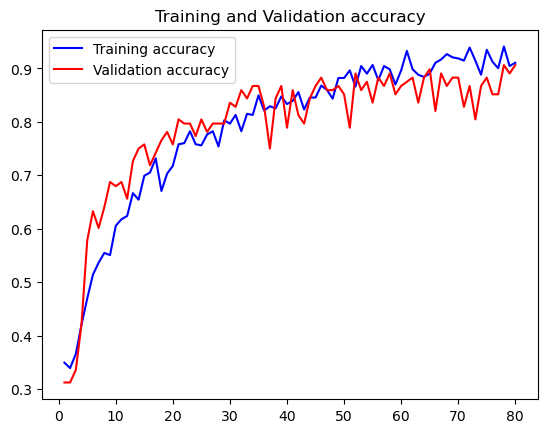

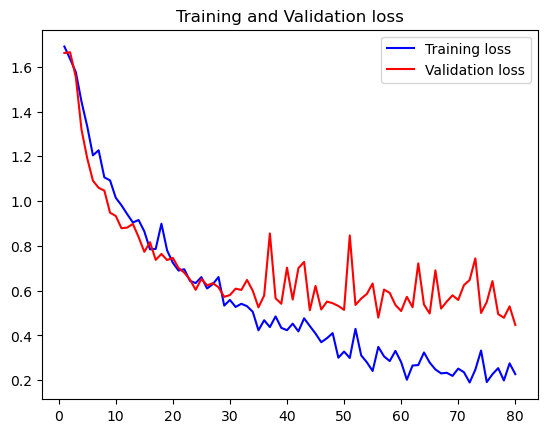

In [17]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import precision_score, f1_score, recall_score

# Assuming you have the model predictions in a variable called y_prob
y_prob = model.predict(x_test)
y_pred = y_prob.argmax(axis=-1)

# Model Evaluation (get accuracy)
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

# Calculate Precision
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='weighted')

# Calculate F1 Score
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='weighted')

# Calculate Recall
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='weighted')

# Print the results
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Recall: {recall:.2f}")

4/4 [==============================] - 0s 72ms/step - loss: 0.4473 - accuracy: 0.9062
Test Accuracy: 90.62%
Precision: 0.91
F1 Score: 0.91
Recall: 0.91


In [19]:
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...


(1, 224, 224, 3)
1/1 [==============================] - 0s 381ms/step
[[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.2758258e-33]]
Predicted Class: BLB
Probability: 1.0000


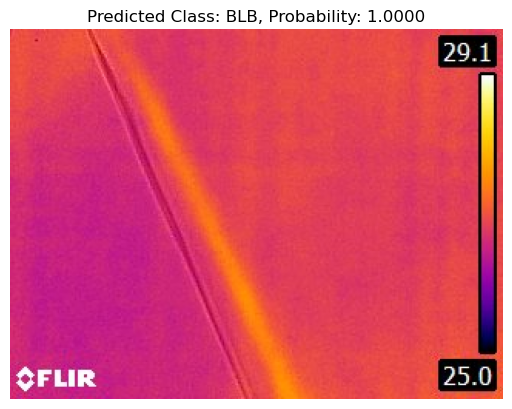

In [20]:
default_image_size = (224, 224)

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/kaggle/input/paddy-diseases/paddy_diseases/thermal images UL/BLB/thermalimage101e.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 224, 224, 3)
1/1 [==============================] - 0s 19ms/step
[[0. 1. 0. 0. 0. 0.]]
Predicted Class: Blast
Probability: 1.0000


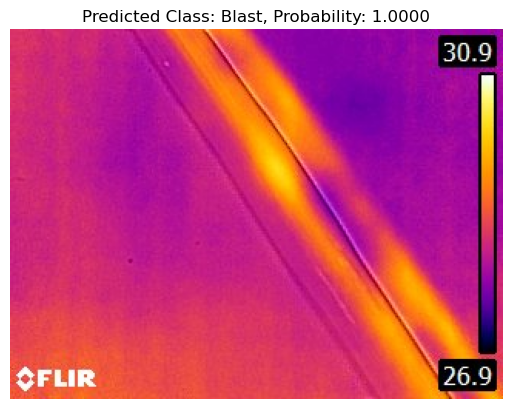

In [21]:
default_image_size = (224, 224)

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/kaggle/input/paddy-diseases/paddy_diseases/thermal images UL/Blast/Thermalimage11b.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 224, 224, 3)
1/1 [==============================] - 0s 20ms/step
[[0.         0.00243995 0.99756    0.         0.         0.        ]]
Predicted Class: healthy
Probability: 0.9976


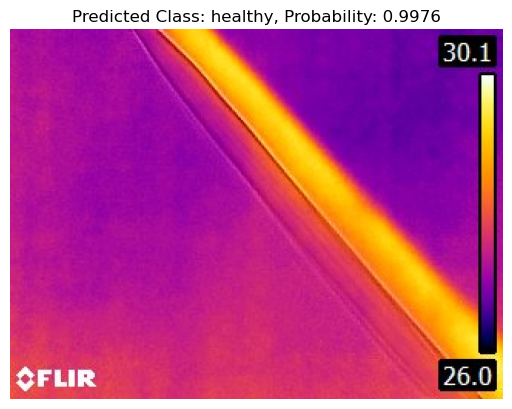

In [22]:
default_image_size = (224, 224)

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/kaggle/input/paddy-diseases/paddy_diseases/thermal images UL/healthy/thermalimage6e.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 224, 224, 3)
1/1 [==============================] - 0s 19ms/step
[[0. 0. 0. 1. 0. 0.]]
Predicted Class: hispa
Probability: 1.0000


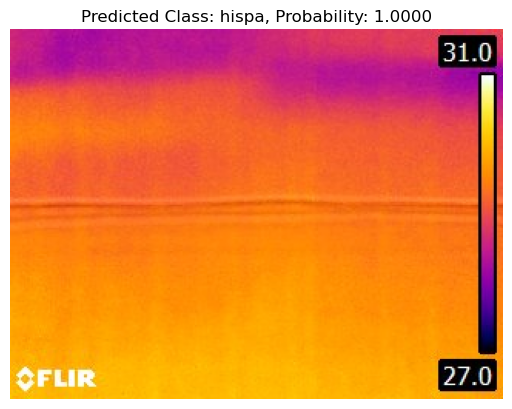

In [23]:
default_image_size = (224, 224)

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/kaggle/input/paddy-diseases/paddy_diseases/thermal images UL/hispa/thermalimage16b.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 224, 224, 3)
1/1 [==============================] - 0s 18ms/step
[[0. 0. 0. 0. 1. 0.]]
Predicted Class: leaf folder
Probability: 1.0000


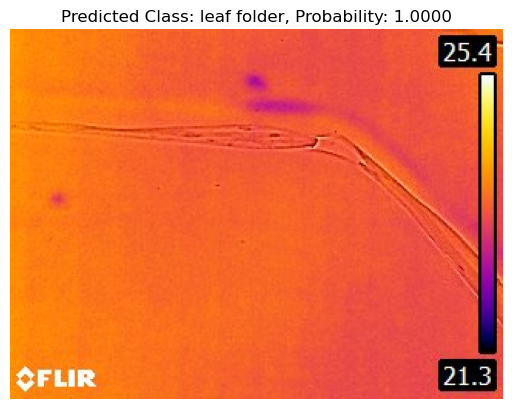

In [24]:
default_image_size = (224, 224)

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/kaggle/input/paddy-diseases/paddy_diseases/thermal images UL/leaf folder/thermalimage15d.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 224, 224, 3)
1/1 [==============================] - 0s 19ms/step
[[3.1088543e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.5319905e-32
  9.9968910e-01]]
Predicted Class: leaf spot
Probability: 0.9997


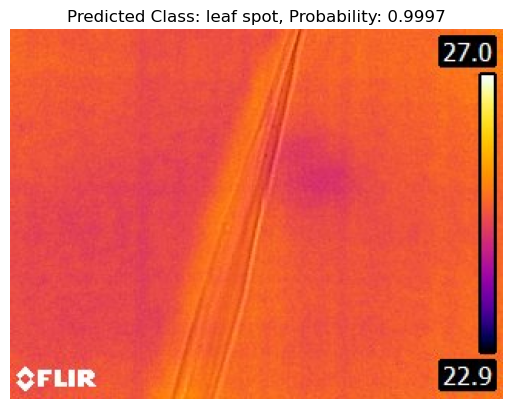

In [25]:
default_image_size = (224, 224)

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/kaggle/input/paddy-diseases/paddy_diseases/thermal images UL/leaf spot/thermalimage2f.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

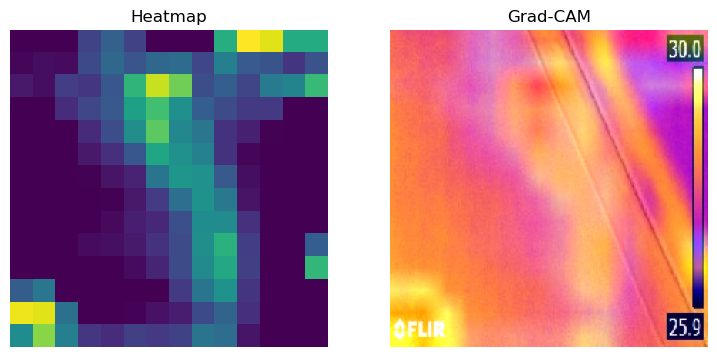

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Function to load and preprocess an image
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to generate GradCAM heatmap and superimposed image
def generate_gradcam(img_path, model, last_conv_layer_name, size=(224, 224), pred_index=None):

    img_array = get_img_array(img_path, size=size)

    # Create a sub-model for GradCAM using specified layers
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Compute the gradient of the top predicted class with respect to activations
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute gradient of the output neuron with respect to feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # mean intensity 
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weighted sum of feature map channels to create heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    # Rescale heatmap to 0-255 and apply jet colormap
    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Resize heatmap to match the dimensions of the original image
    original_img = image.load_img(img_path, target_size=size)
    original_img = image.img_to_array(original_img)
    resized_heatmap = cv2.resize(jet_heatmap, (original_img.shape[1], original_img.shape[0]))

    # Overlay heatmap on the original image
    superimposed_img = resized_heatmap * 0.4 + original_img / 255.0
    superimposed_img = np.clip(superimposed_img, 0, 1)

    return heatmap, superimposed_img

last_conv_layer_name = "block5_conv3"  # VGG16 specific last convolutional layer

img_path = '/kaggle/input/paddy-diseases/paddy_diseases/thermal images UL/Blast/Thermalimage10b.jpg'

model = VGG16(weights='imagenet', include_top=True)

heatmap, superimposed_img = generate_gradcam(img_path, model, last_conv_layer_name)

# Display the heatmap
plt.figure(figsize=(9, 8))
plt.subplot(1, 2, 1)
plt.imshow(heatmap, cmap='viridis')
plt.axis('off')
plt.title('Heatmap')

# Display the grad-cam image
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.axis('off')
plt.title('Grad-CAM')

plt.show()
